In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
colours=['Green','Navy_Blue','Cyan','Red','Yellow','Brown','Black','Grey']
h=48
b=64

# Initial Data Processing

In [ ]:
%cd '/content/drive/My Drive/Images'

/content/drive/My Drive/Images


In [ ]:
def load(img_name):
  img=cv2.imread(img_name,1)
  img=cv2.resize(img,(960,540))
  img_new=img[106:488,245:754,:]
  img_new=cv2.resize(img_new,(b,h))
  return img_new


In [ ]:
m_train=0
for colour in colours :
  filenames=glob.glob('Torus_'+colour+'/*.png')
  m_train+=len(filenames)
  print(len(filenames))

40
40
40
40
40
40
39
40


In [ ]:
m_train=0
for colour in colours :
  filenames=glob.glob('Torus_'+colour+'/*.png')
  m_train+=len(filenames)

train_X=np.zeros([m_train,h,b,3])
train_y=np.zeros([m_train,1])

ind=0
for i in range(8):
  filenames=glob.glob('Torus_'+colours[i]+'/*.png')
  for image_name in filenames :
    train_X[ind]=load(image_name)
    train_y[ind]=i
    ind+=1



m_valid=0
for colour in colours :
  filenames=glob.glob('Torus_'+colour+'/Valid/*')
  m_valid+=len(filenames)

valid_X=np.zeros([m_valid,h,b,3])
valid_y=np.zeros([m_valid,1])

ind=0
for i in range(8):
  filenames=glob.glob('Torus_'+colours[i]+'/Valid/*')
  for image_name in filenames :
    valid_X[ind]=load(image_name)
    valid_y[ind]=i
    ind+=1

In [ ]:
print(len(y_train),len(y_valid))

6380 640


In [ ]:
train_data_gen=ImageDataGenerator(
    height_shift_range=0.05,
    width_shift_range=0.05,
    rotation_range=50,                                                
    zoom_range=[0.6,1.15]                       
)

valid_data_gen=ImageDataGenerator(
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=50,                                                
    zoom_range=[0.8,1.2]                       
)

In [ ]:
m_train=len(train_y)
factor=20

X_train=np.zeros([factor*m_train,h,b,3])                                
y_train=np.zeros([factor*m_train,1])
for i in range(factor):                                                    
  it=train_data_gen.flow(train_X,train_y,batch_size=m_train)                        
  temp=next(it)
  X_train[i*m_train:(i+1)*m_train,:,:,:]=temp[0]                                 
  y_train[i*m_train:(i+1)*m_train,:]=temp[1]  


m_valid=len(valid_y)
factor=5
X_valid=np.zeros([factor*m_valid,h,b,3])                                
y_valid=np.zeros([factor*m_valid,1])
for i in range(factor):                                                    
  it=valid_data_gen.flow(valid_X,valid_y,batch_size=m_valid)                        
  temp=next(it)
  X_valid[i*m_valid:(i+1)*m_valid,:,:,:]=temp[0]                                 
  y_valid[i*m_valid:(i+1)*m_valid,:]=temp[1]

In [ ]:
pos=np.arange(len(y_train))
np.random.shuffle(pos)          
X_train=X_train[pos]
y_train=y_train[pos]

pos=np.arange(len(y_valid))
np.random.shuffle(pos)          
X_valid=X_valid[pos]
y_valid=y_valid[pos]

In [ ]:
%cd '/content/drive/My Drive/Project_Data/Task_1b'

np.save('X_train',X_train)
np.save('y_train',y_train)
np.save('X_valid',X_valid)
np.save('y_valid',y_valid)

/content/drive/My Drive/Project_Data


In [ ]:
%cd '/content/drive/My Drive/Project_Data/Task_1b'

X_train=np.load('X_train.npy')
y_train=np.load('y_train.npy')
X_valid=np.load('X_valid.npy')
y_valid=np.load('y_valid.npy')

/content/drive/My Drive/Project_Data


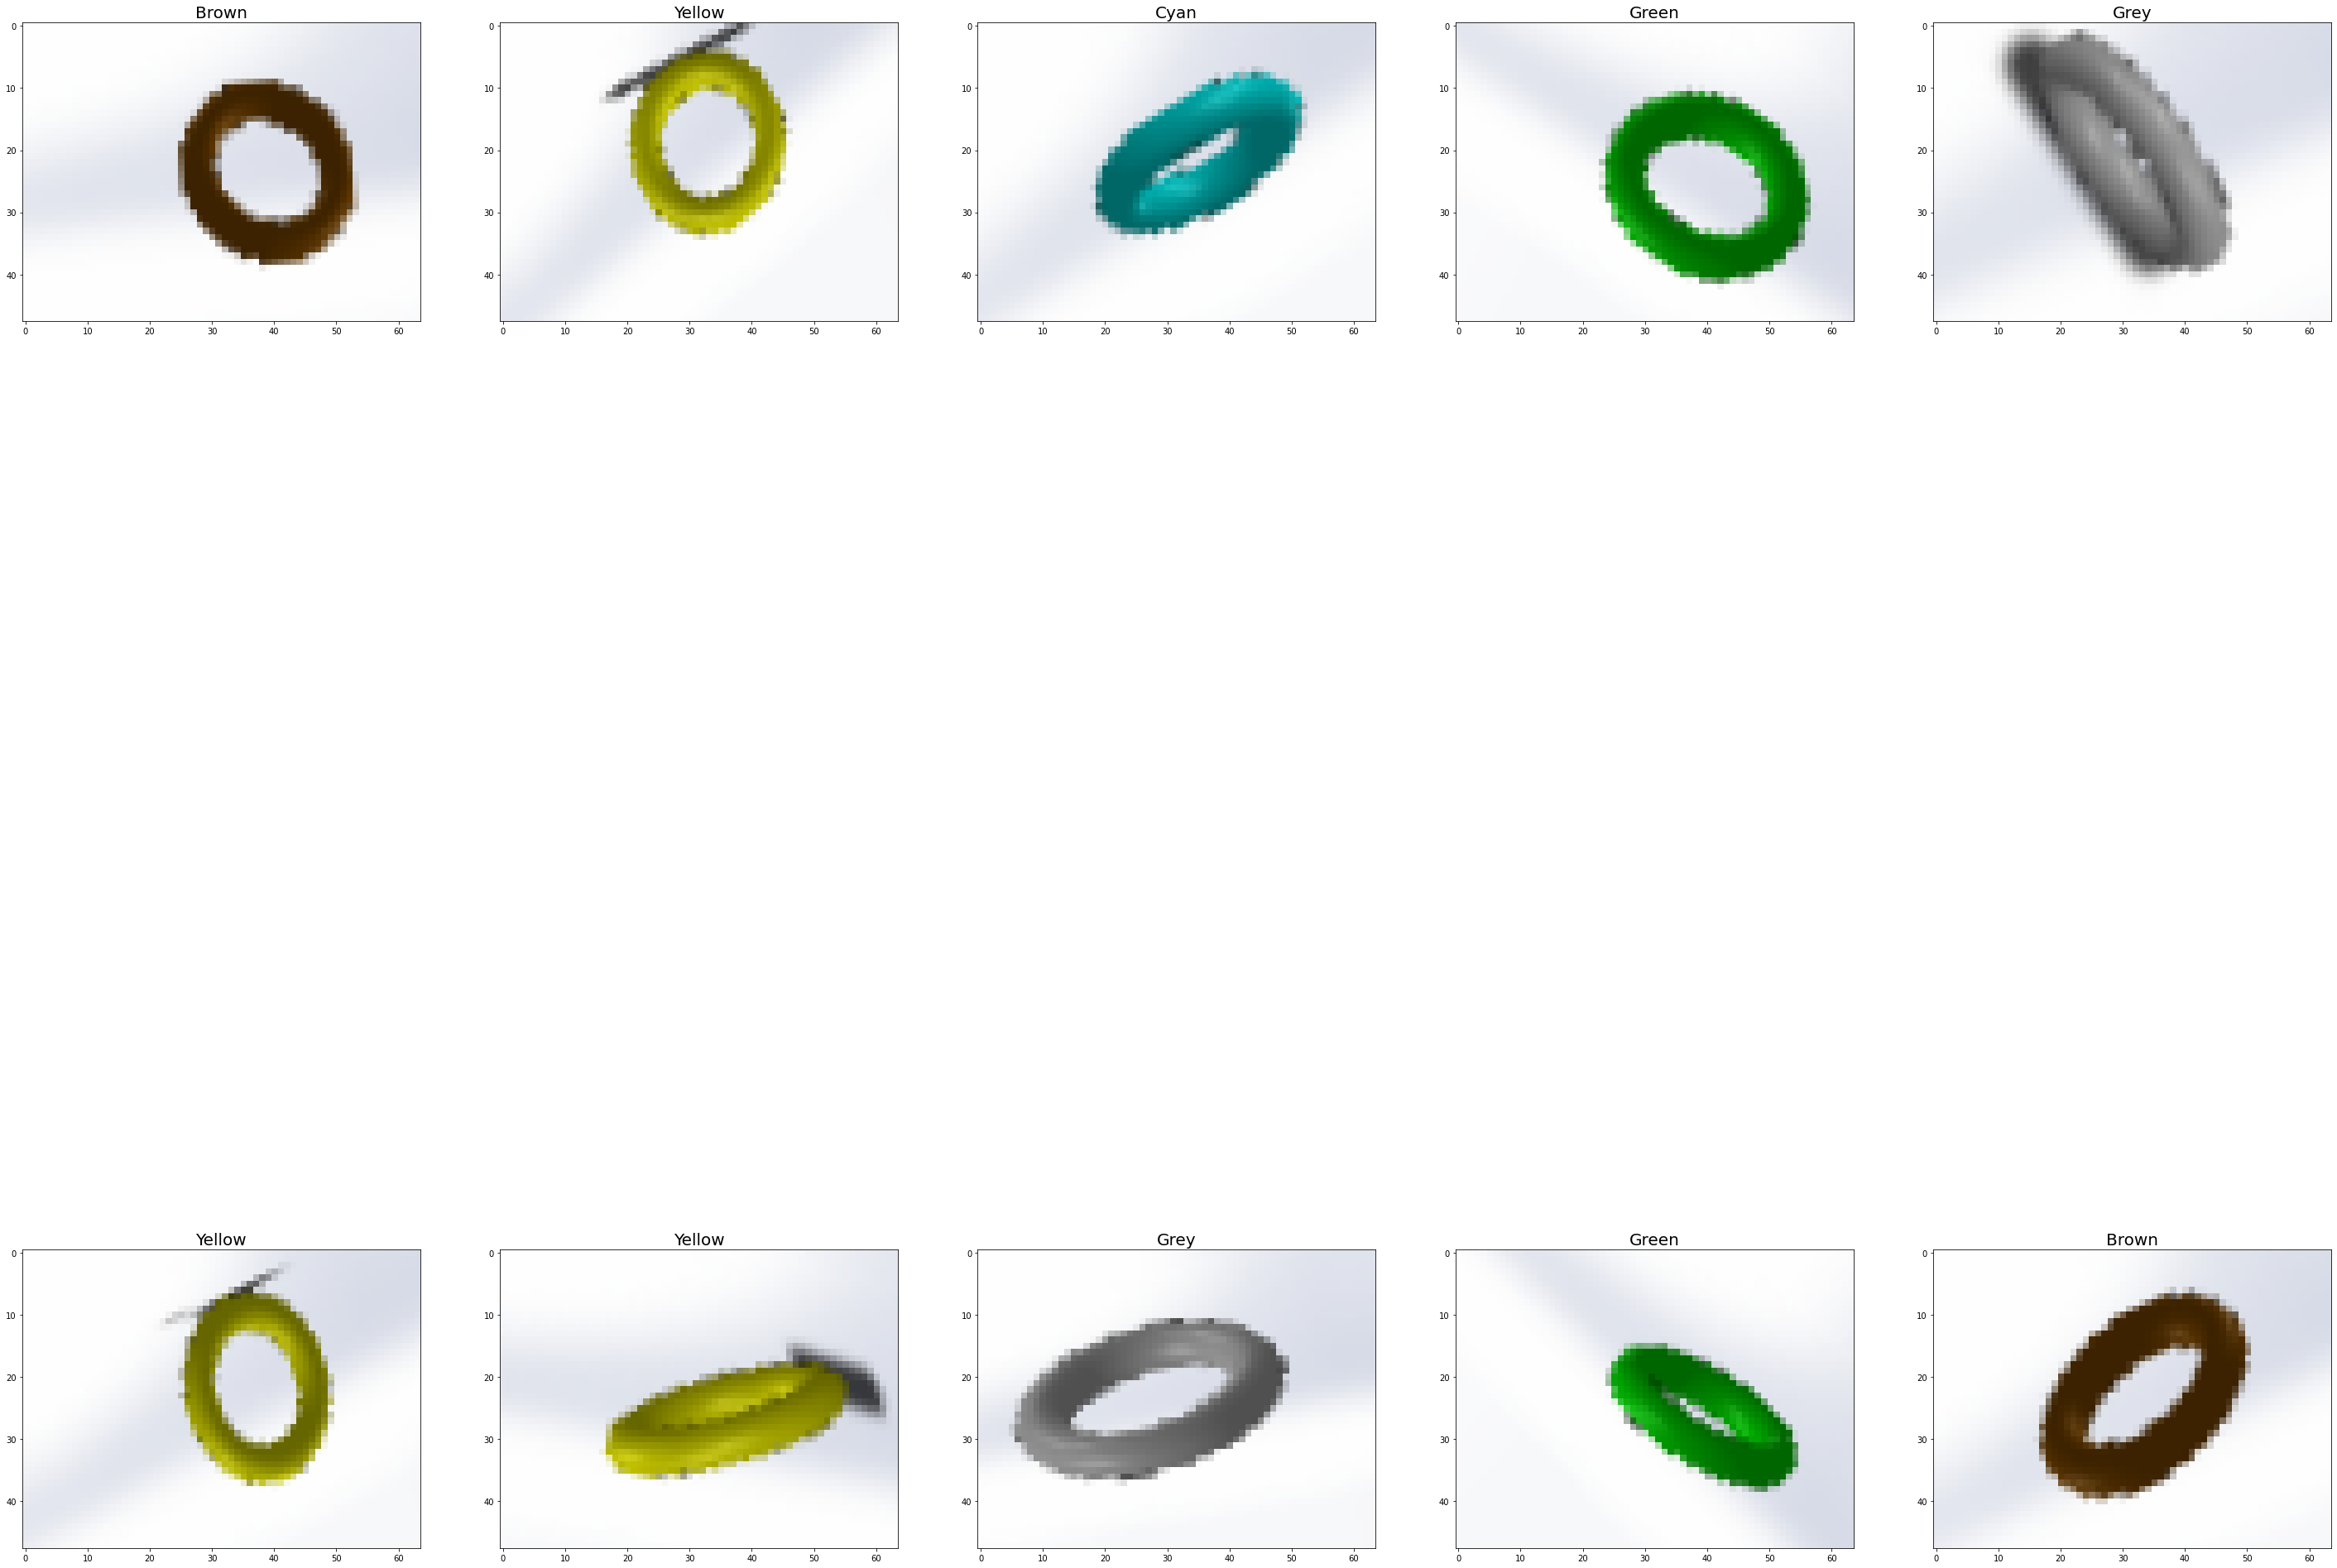

In [ ]:
fig=plt.figure(figsize=(50,50))   
for i in range(10):
  startind=120
  sub=fig.add_subplot(2,5,i+1)
  img=X_train[i+startind].copy()
  #img=img.reshape((h,b))
  sub.imshow(cv2.cvtColor(img.astype(np.uint8),cv2.COLOR_BGR2RGB))
  #temp=y_train[i]
  plt.title(colours[int(y_train[i+startind])],fontsize=20)        
plt.show()

In [ ]:
X_train=X_train/255.0
X_valid=X_valid/255.0

In [ ]:
inputs=tf.keras.Input(shape=(h,b,3))

x=Conv2D(16,3,1,padding='same')(inputs)
#x=BatchNormalization()(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(32,3,1,padding='same')(x)
#x=Conv2D(32,3,1,padding='same')(x)
x=BatchNormalization()(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(64,3,1,padding='same')(x)
#x=Conv2D(64,3,1,padding='same')(x)
#x=BatchNormalization()(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(128,3,1,padding='same')(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Flatten()(x)
output=Dense(8,activation='softmax')(x)

model=tf.keras.Model(inputs,output,name='model1b')

model.compile(optimizer='adagrad',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "model1b"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 64, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 64, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 32, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 32, 32)        4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 32, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 16, 64)        1849

In [ ]:
epochs=2
history=model.fit(X_train,
                  y_train,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(X_valid,y_valid))

Epoch 1/2
200/200 [==============================] - 23s 113ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9859
Epoch 2/2
200/200 [==============================] - 22s 112ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0415 - val_accuracy: 0.9891


Text(0.5, 1.0, 'Training and Validation Accuracy')

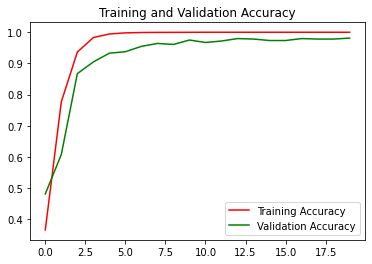

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs_range=range(epochs)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color='green')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

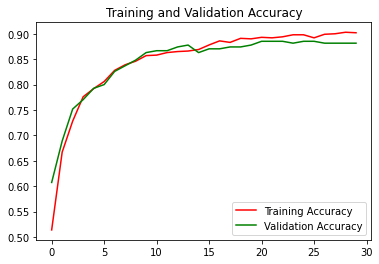

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs_range=range(epochs)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color='green')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
arrBG=X_train[:,:,:,0]-X_train[:,:,:,1]
arrGR=X_train[:,:,:,1]-X_train[:,:,:,2]
arrRB=X_train[:,:,:,2]-X_train[:,:,:,0]
arr=np.zeros([len(y_train),h,b,3])
arr[:,:,:,0]=arrBG
arr[:,:,:,1]=arrGR
arr[:,:,:,2]=arrRB


In [ ]:
predictions=model.predict(X_valid).astype(float)
tf.math.confusion_matrix(y_valid.reshape(len(y_valid),),np.argmax(predictions,axis=1))

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[80,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 80,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 78,  0,  0,  0,  0,  2],
       [ 0,  0,  0, 80,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 80,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 79,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 76,  4],
       [ 0,  0,  0,  0,  0,  0,  0, 80]], dtype=int32)>

In [ ]:
model.save("model1b_9891.h5")